In [3]:
import csv
from itertools import combinations
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


import folium

import folium
from folium import GeoJson
import geopandas as gpd

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import networkx as nx
import folium
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import random
from pyproj import Proj, transform
import plotly.graph_objects as go




from shapely.geometry import LineString
import math
import networkx as nx
from shapely.geometry import LineString
from shapely import simplify
import math
import networkx as nx
import folium

- **distance_Km:** This refers to the actual physical distance between two locations in kilometers. In the code, it is extracted from the CSV data and represents the distance traveled along each edge in the network graph.

For example, if a path consists of two edges where the first edge's `distance_Km` is 50 Km and the second edge's `distance_Km` is 100 Km, and the total distance of the path (`total_distance_Km`) is 200 Km, then:

These values indicate the proportional contribution of each edge to the total distance traveled along the path.


- **Points to work:**

- Paths: Let's say we are require to traverse from memphis to atlanta, we should either take nashville or birminham. Nevertheless, we have a route from memphis to altanta directly. SHould we delete this? Under what criteria. This problem gets fixed in some extend if we take the shortest path.

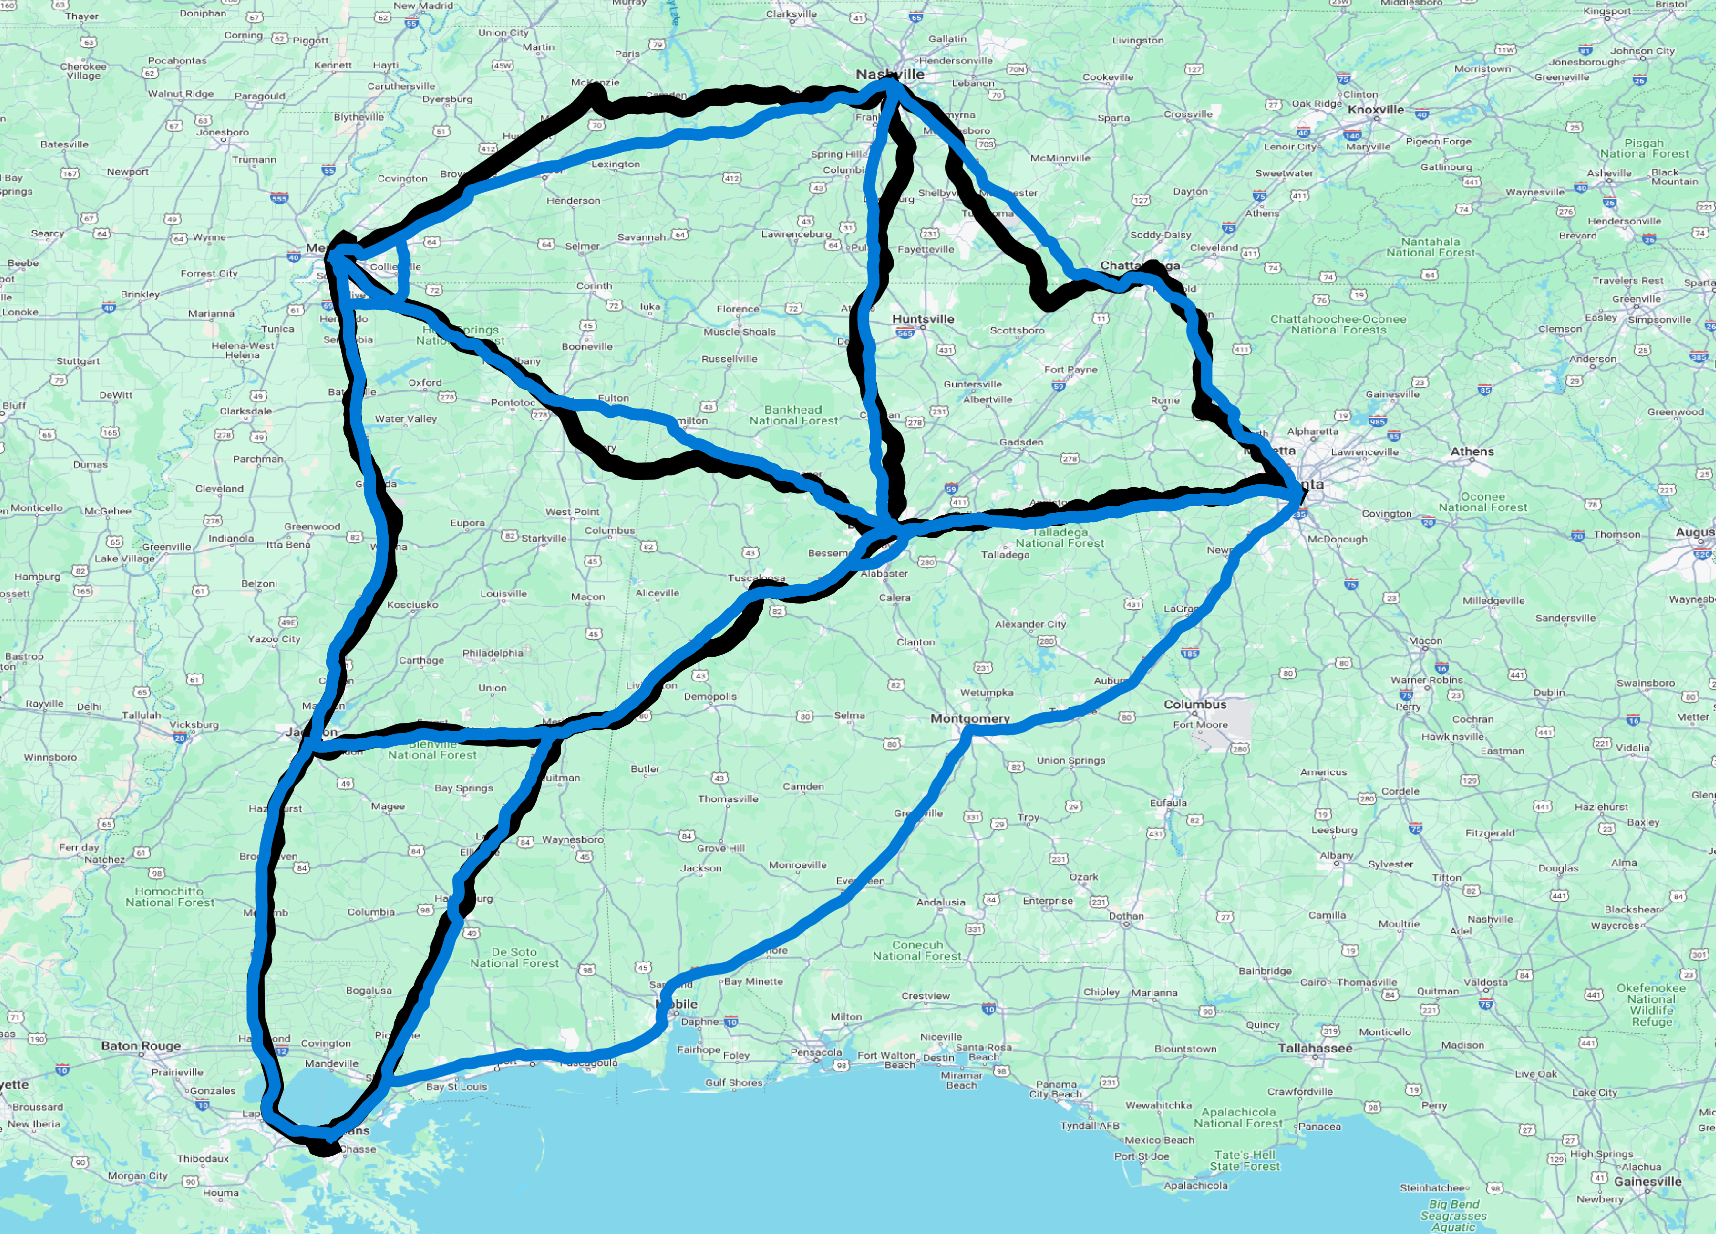

- **Pre calculated distances:**
All pre calculated distances should come from the new workflow.

In [4]:

def filter_city_combinations(input_csv, cities):
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(input_csv)
    
    # Assuming the first two columns are OD pairs
    od_pairs = df.iloc[:, :2]
    
    # Get combinations of the specified cities
    selected_combinations = list(combinations(cities, 2))
    selected_combinations += [(dest, src) for src, dest in selected_combinations]  # Reverse combinations
    
    # Filter rows that contain any of the specified combinations
    filtered_df = od_pairs.apply(tuple, axis=1).isin(selected_combinations)
    
    # Extract rows that match the OD pairs
    result_df = df[filtered_df]
    
    # Write the filtered rows into a new CSV
    result_df.to_csv("output_csv.csv", index=False)

    return result_df
    


def create_graph(graph_data):
    """ 
    Function:
    Creates a networkx graph using the information in the graph data provided

    Input:
    graph_data (pandas dataframe): containing the following columns:  'dms_orig', 'dms_dest', 'dms_mode', 'latitude_dms_orig',
       'longitude_dms_orig', 'latitude_dms_dest', 'longitude_dms_dest',
       'distance_km'

    Output:
    a networkx graph object
     
     """


    graph = nx.Graph()
    print(graph_data.columns)
    for _,row in graph_data.iterrows():
        graph.add_edge(row['dms_orig'], row['dms_dest'],distance =row["distance_km"], mode = row['dms_mode'])
        graph.nodes[row['dms_orig']]['pos'] = (row['longitude_dms_orig'], row['latitude_dms_orig'])
        graph.nodes[row['dms_dest']]['pos'] = (row['longitude_dms_dest'], row['latitude_dms_dest'])
    return graph



def draw_graph(graph):
    """" Visulaizes a given networkx graph"""
    edge_modes = [graph[u][v]['mode'] for u,v in graph.edges()]
    color = {'rail': 'green', 'road': 'black', 'water': 'blue'}
    edge_colors = [color[mode] for mode in edge_modes]
    pos = nx.get_node_attributes(graph, 'pos')
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=800,edge_color = edge_colors, font_weight='bold')
    plt.show()



def get_edge_details(graph, path):
    """Provides a dictionary with each edge in a path as a key and the start, end positions, mode, and distance as values."""
    
    edge_details = []
    total_distance = 0  # Initialize total distance
    
    for start, end in zip(path[:-1], path[1:]):
        edge_info = {
            'edge': (start, end),
            'start_pos': graph.nodes[start]['pos'],
            'end_pos': graph.nodes[end]['pos'],
            'mode': graph[start][end]['mode'],
            'distance_km': graph[start][end]['distance']  # Add distance information
        }
        edge_details.append(edge_info)
        total_distance += edge_info['distance_km']  # Accumulate total distance

    # Calculate distance per edge and include in the result
    for edge_info in edge_details:
        edge_info['distance_per_edge_km'] = edge_info['distance_km'] / total_distance * 100

    # Include total distance in the result
    edge_details.append({'total_distance_km': total_distance})
    
    return edge_details

def get_all_paths(graph, origin, destination, get_path_details):
    """Get all possible paths between an origin and detaination pair in a given graph

    This function also provides the details(start position, end position and mode) of all edges in each path
      if getPathDetails is set to be true

    The function returns a dictionary with the path number as the key and the details of the path as the values
    if getPathDetails is set to be True and returns a simple list of all paths if getPathDetails is set to be 
    False
    
    """

    all_paths = list(nx.all_simple_paths(graph, source=origin, target=destination))
    details =  {}
    if get_path_details:
        for path_num in range(len(all_paths)):
            details[path_num] = get_edge_details(graph, all_paths[path_num])
        return details
    else:
        return all_paths
    


def get_k_shortest_paths(graph, origin, destination, get_path_details, k):
    """Get the k shortest paths between an origin and detaination pair in a given graph

    This function also provides the details(start position, end position and mode) of all edges in each path
      if getPathDetails is set to be true

    The function returns a dictionary with the path number as the key and the details of the path as the values
    if getPathDetails is set to be True and returns a simple list of the shortest paths if getPathDetails is set to be 
    False
    
    """

    simple_paths = nx.shortest_simple_paths(graph, origin, destination)
    shortest_paths = []
    for counter, path in enumerate(simple_paths):
        shortest_paths.append(path)
        if counter == k-1:
            break

    details =  {}
    if get_path_details:
        for path_num in range(len(shortest_paths)):
            details[path_num] = get_edge_details(graph, shortest_paths[path_num])
        return details
    else:
        return shortest_paths



def calculate_emissionsLCA(routes):
    # print("report")

    co2_emissions = {
        'rail': 24.77771215,  # g/ton. miles (Freight_Rail_Diesel)
        'road': 1583.0493,  # g/miles (Long_Haul_Trucks_Road_Conventional_and_LS_Diesel)
        'water': 94667.60075,  # g/mm.Btu (NE_Marine_HFO_2.7%_sulfur)
    }
    
    # co2_emissions=pd.read_csv('Emission  Rates.csv')
    path_data=routes
    # Calculate CO2 emissions for each edge based on distance and transportation mode
    total_emissions = 0
    for edge_data in path_data[:-1]:
        key = edge_data['mode']
        if key in co2_emissions:
            
            co2_per_unit = co2_emissions[key]
            # print(co2_per_unit)
            distance_km = edge_data['distance_km'] / 1000  # Convert to km
            co2_emission = co2_per_unit * distance_km
            total_emissions += co2_emission
            print(f"CO2 emissions for {edge_data['mode'].replace('_', ' ')} from {edge_data['edge'][0]} to {edge_data['edge'][1]}: {co2_emission} g")
    
    # Print total CO2 emissions for the entire path
    print(f"Total CO2 emissions for the path: {total_emissions} g")


def plotting_GIS(routes):
    # Create a folium map centered around the midpoint of all start and end positions
    map_center = ((32.284748 + 36.1622767) / 2, (-90.196984 + -86.7742984 + -86.7742984 + -86.765783) / 4)
    mymap = folium.Map(location=map_center, zoom_start=6)
    
    # Add markers for start and end positions of each edge
    edges_data = [
        {'edge': ('Jackson MS', 'Nashville TN'), 'start_pos': (32.284748, -90.196984), 'end_pos': (36.1622767, -86.7742984)},
        {'edge': ('Nashville TN', 'Birmingham AL'), 'start_pos': (36.1622767, -86.7742984), 'end_pos': (33.570499, -86.765783)}
    ]
    
    for edge_data in edges_data:
        start_marker = folium.Marker(location=edge_data['start_pos'], popup=edge_data['edge'][0], icon=folium.Icon(color='green'))
        end_marker = folium.Marker(location=edge_data['end_pos'], popup=edge_data['edge'][1], icon=folium.Icon(color='red'))
        mymap.add_child(start_marker)
        mymap.add_child(end_marker)
    
    # Display the map
    mymap.save('my_map.html')  # Save the map as an HTML file
    mymap

In [6]:
# !pwd && ls

/home/jose/RECOIL_Data_Collection/small_set
 Data_generation_S.py   map.html      network.csv      Untitled-Copy1.ipynb
'Emission  Rates.csv'   my_map.html   output_csv.csv   Untitled.ipynb


In [7]:

if __name__ == "__main__":
    input_csv = "network.csv"  # Input CSV path
    output_csv = "data_OD.csv"  # Output CSV
    cities = ["Atlanta GA", "Memphis TN", "Birmingham AL", "Nashville TN", "Jackson MS", "New Orleans LA"]
    
    graph_data = filter_city_combinations(input_csv, cities)
    graph = create_graph(graph_data)

    ## Get all the possible routes between two locations
    # routes = get_all_paths(graph, 'Nashville TN', 'Memphis TN', True)#False
    routes = get_k_shortest_paths(graph, 'Jackson MS', 'Birmingham AL', True, 5)

    # routes = get_all_paths(graph, 'Nashville TN', 'New Orleans LA', True)#False



    

    ## Print the details of a Sample Route
    print("Path Under Study", routes[1])

    #TODO
    report=calculate_emissionsLCA(routes[1])


    # mymap=plotting_GIS(routes[1])
    # mymap

    



   

Index(['dms_orig', 'dms_dest', 'dms_mode', 'latitude_dms_orig',
       'longitude_dms_orig', 'latitude_dms_dest', 'longitude_dms_dest',
       'distance_km'],
      dtype='object')
Path Under Study [{'edge': ('Jackson MS', 'Atlanta GA'), 'start_pos': (-90.196984, 32.284748), 'end_pos': (-84.3902644, 33.7489924), 'mode': 'rail', 'distance_km': 611373.1538819256, 'distance_per_edge_km': 72.26656445817211}, {'edge': ('Atlanta GA', 'Birmingham AL'), 'start_pos': (-84.3902644, 33.7489924), 'end_pos': (-86.765783, 33.570499), 'mode': 'rail', 'distance_km': 234624.10427718947, 'distance_per_edge_km': 27.733435541827888}, {'total_distance_km': 845997.2581591151}]
CO2 emissions for rail from Jackson MS to Atlanta GA: 15148.428023124008 g
CO2 emissions for rail from Atlanta GA to Birmingham AL: 5813.448519231784 g
Total CO2 emissions for the path: 20961.876542355792 g


In [9]:
output_file='../data_intermodal/RailNetwork_ExportFeatures.geojson'

In [10]:
gdf = gpd.read_file(output_file)
print(gdf.shape)

(22389, 11)


In [11]:
# Define the target CRS (WGS84, EPSG:4326)
#Transform all geometries in an active geometry column to a different coordinate reference system.
#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html
target_crs = 'EPSG:4326'

# Convert the GeoDataFrame to the target CRS
gdf[target_crs] = gdf.to_crs(target_crs)['geometry']


   Name                       Link_Type  Dir_Flag  Volume  Capacity  VCR  \
0  ACEX  4: Class 1 Rights non-STRACNET         0     0.0       0.0  0.0   
1   ALS  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   
2   ALS  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   
3   ALS  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   
4    AM  4: Class 1 Rights non-STRACNET         0     0.0     600.0  0.0   

   Artificial  Shape_Leng Mode_Type    Length  \
0           0  610.913717      rail  0.379603   
1           0  116.214450      rail  0.072212   
2           0  228.146527      rail  0.141763   
3           0  323.384390      rail  0.200941   
4           0  518.217930      rail  0.322005   

                                            geometry  \
0  LINESTRING (-2181490.871 190275.547, -2181497....   
1  LINESTRING (508036.049 -29506.068, 508040.415 ...   
2  LINESTRING (508078.740 -29223.481, 508108.279 ...   
3  LINESTRING (508112.93

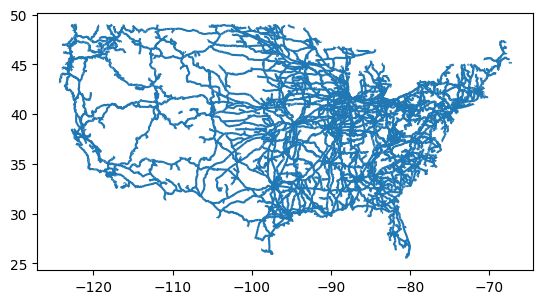

In [12]:
# Create a GeoDataFrame from the data
rail = gpd.GeoDataFrame(gdf, geometry='EPSG:4326')
print(rail.head())
# Plot the GeoDataFrame
fig, ax = plt.subplots()
rail.plot(ax=ax)
plt.show()

In [13]:
output_file='../data_intermodal/WaterNetwork_ExportFeatures.geojson'

In [14]:
gdf = gpd.read_file(output_file)
print(gdf.shape)

(6175, 13)


In [15]:
# Define the target CRS (WGS84, EPSG:4326)
target_crs = 'EPSG:4326'

# Convert the GeoDataFrame to the target CRS
gdf[target_crs] = gdf.to_crs(target_crs)['geometry']


# Print the updated GeoDataFrame
gdf.columns

Index(['Name', 'Link_Type', 'Dir_Flag', 'Volume', 'Capacity', 'VCR',
       'Artificial', 'Mode_Type', 'ORIG_FID', 'ORIG_SEQ', 'Shape_Leng',
       'Length', 'geometry', 'EPSG:4326'],
      dtype='object')

                 Name      Link_Type  Dir_Flag  Volume  Capacity  VCR  \
6170  YAZOO RIVER, MS   4: No Volume         0     0.0       0.0  0.0   
6171   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   
6172   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   
6173   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   
6174   YORK RIVER, VA  3: Low Volume         0     0.0       0.0  0.0   

      Artificial Mode_Type  ORIG_FID  ORIG_SEQ     Shape_Leng      Length  \
6170           0     water      6062         1  259003.627409  160.937071   
6171           0     water      6063         1   14985.630223    9.311620   
6172           0     water      6064         1   15456.209073    9.604024   
6173           0     water      6065         1   10922.080885    6.786653   
6174           0     water      6066         1   28655.148622   17.805448   

                                               geometry  \
6170  LINESTRING (539607.591 -584881.64

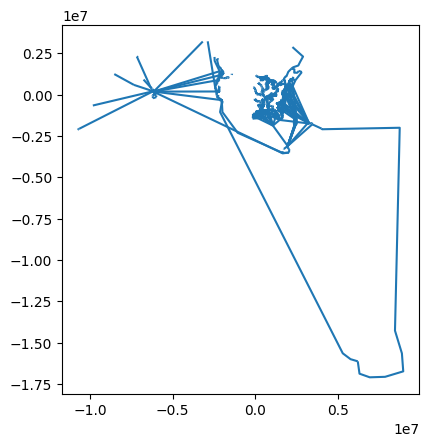

In [16]:
# Create a GeoDataFrame from the data
water = gpd.GeoDataFrame(gdf, geometry='geometry')
print(water.tail())
# Plot the GeoDataFrame
fig, ax = plt.subplots()
water.plot(ax=ax)
plt.show()

In [17]:
output_file='../data_intermodal/RoadNetwork_ExportFeatures.geojson'

In [18]:
gdf = gpd.read_file(output_file)
# print(gdf.shape)

In [19]:
# Define the target CRS (WGS84, EPSG:4326)
target_crs = 'EPSG:4326'

# Convert the GeoDataFrame to the target CRS
gdf[target_crs] = gdf.to_crs(target_crs)['geometry']

# Print the updated GeoDataFrame


   Free_Speed  Name Link_Type  Dir_Flag  Urban_Rura  Limited_Ac  Volume  \
0          45  None      None         0           0           0     0.0   
1          45  None      None         0           0           0     0.0   
2          45  None      None         0           0           0     0.0   
3          45  None      None         0           0           0     0.0   
4          45  None      None         0           0           0     0.0   

   Capacity  VCR  Artificial  SHAPE_Leng Mode_Type    Length  \
0       0.0  0.0           0   29.558085      road  0.018367   
1       0.0  0.0           0  132.616081      road  0.082404   
2       0.0  0.0           0  475.141730      road  0.295239   
3       0.0  0.0           0  145.609211      road  0.090477   
4       0.0  0.0           0   78.027052      road  0.048484   

                                            geometry  \
0  LINESTRING (-770448.594 -81202.100, -770422.21...   
1  LINESTRING (-770422.212 -81215.430, -770302.89...

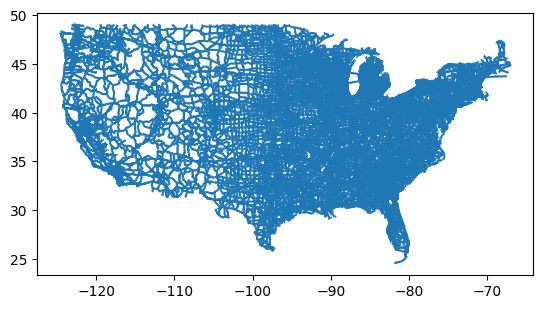

In [20]:
# Create a GeoDataFrame from the data
road = gpd.GeoDataFrame(gdf, geometry='EPSG:4326')
print(road.head())
# Plot the GeoDataFrame
fig, ax = plt.subplots()
road.plot(ax=ax)
plt.show()

In [21]:
rail=rail[['Mode_Type','Length','EPSG:4326']]
rail.tail()

Mode_Type     Length                                          EPSG:4326
22384      rail  37.224060  LINESTRING (-80.59676 41.06139, -80.59806 41.0...
22385      rail   9.213283  LINESTRING (-105.42946 48.79225, -105.42900 48...
22386      rail  30.094301  LINESTRING (-80.61694 36.50451, -80.61683 36.5...
22387      rail  59.352077  LINESTRING (-81.11607 36.17309, -81.11367 36.1...
22388      rail   8.590879  LINESTRING (-122.63334 41.70857, -122.63333 41...

In [22]:
road=road[['Mode_Type','Length','EPSG:4326']]
road.tail()

Mode_Type    Length                                          EPSG:4326
437357      road  7.531009  LINESTRING (-122.68825 47.00914, -122.68848 47...
437358      road  0.350505  LINESTRING (-87.93994 41.89702, -87.93992 41.8...
437359      road  1.548574  LINESTRING (-87.93971 41.97603, -87.93971 41.9...
437360      road  0.148462  LINESTRING (-80.14230 26.01067, -80.14219 26.0...
437361      road  4.935153  LINESTRING (-117.11892 34.02759, -117.11887 34...

In [23]:
water=water[['Mode_Type','Length','EPSG:4326']]
water.tail()
water.iloc[0,-2:]

Length                                             2328.432764
EPSG:4326    LINESTRING (-157.89248559806316 21.25332657248...
Name: 0, dtype: object

In [24]:
# Concatenate the subsets into a single GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat([rail, road, water], ignore_index=True))

# Display the combined GeoDataFrame
print(combined_gdf.head())

  Mode_Type    Length                                          EPSG:4326
0      rail  0.379603  LINESTRING (-121.27883 37.95737, -121.27858 37...
1      rail  0.072212  LINESTRING (-90.13343 38.58417, -90.13338 38.5...
2      rail  0.141763  LINESTRING (-90.13273 38.58670, -90.13240 38.5...
3      rail  0.200941  LINESTRING (-90.13248 38.58491, -90.13219 38.5...
4      rail  0.322005  LINESTRING (-93.92970 36.91773, -93.92887 36.9...


In [48]:




def calculate_distance(point1, point2):
    """Calculate the distance between two points using Haversine formula."""
    # Convert decimal degrees to radians
    lat1, lon1 = math.radians(point1[0]), math.radians(point1[1])
    lat2, lon2 = math.radians(point2[0]), math.radians(point2[1])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth in meters
    R = 6371000

    # Calculate distance
    distance = R * c
    return distance

def find_nearest_node(graph, point):
    """Find the nearest node in the graph to the given point."""
    return min(graph.nodes, key=lambda node: calculate_distance(point, node))


# del mymap
# Create a Folium map
mymap = folium.Map(location=(-90.7742984, 36.1622767), zoom_start=5)


for step in routes[1]:
    #print(step)
    # print("@@@@@@")
    if 'edge' in step:
        #print(step)
        # print(step)
        edge = step['edge']
        start_pos = step['start_pos']
        end_pos = step['end_pos']
        mode = step['mode']
        distance_km = step['distance_km']
        print("step")
        # print(step)
        #print("step")




        if mode=='road':
            # Assuming 'road' is your GeoDataFrame containing road data
            G = nx.Graph()
            
            # Loop through 'rail' data and add edges to the graph
            for idx, row in road.iterrows():
                geom = row['EPSG:4326']
                if isinstance(geom, LineString):
                    # Simplify the LineString geometry
                    simplified_geom = simplify(geom, tolerance=0.001, preserve_topology=False)  # Adjust tolerance as needed
                    
                    nodes = list(simplified_geom.coords)
                    for i in range(len(nodes) - 1):
                        distance = calculate_distance(nodes[i], nodes[i + 1])
                        G.add_edge(nodes[i], nodes[i + 1], weight=distance)
                    
        elif mode=='rail':
            # Assuming 'road' is your GeoDataFrame containing road data
            G = nx.Graph()
            
            # Loop through your data and add edges to the graph
            for idx, row in rail.iterrows():
                geom = row['EPSG:4326']
                if isinstance(geom, LineString):
                    # Simplify the LineString geometry
                    simplified_geom = simplify(geom, tolerance=0.001, preserve_topology=False)  # Adjust tolerance as needed
                    
                    nodes = list(simplified_geom.coords)
                    for i in range(len(nodes) - 1):
                        distance = calculate_distance(nodes[i], nodes[i + 1])
                        G.add_edge(nodes[i], nodes[i + 1], weight=distance)
            
        elif mode=='water':
            # Assuming 'road' is your GeoDataFrame containing road data
            G = nx.Graph()
            
            # Loop through your data and add edges to the graph
            for idx, row in water.iterrows():
                geom = row['EPSG:4326']
                if isinstance(geom, LineString):
                    # Simplify the LineString geometry
                    simplified_geom = simplify(geom, tolerance=0.001, preserve_topology=False)  # Adjust tolerance as needed
                    
                    nodes = list(simplified_geom.coords)
                    for i in range(len(nodes) - 1):
                        distance = calculate_distance(nodes[i], nodes[i + 1])
                        G.add_edge(nodes[i], nodes[i + 1], weight=distance)
        
        source_node = find_nearest_node(G, start_pos)
        target_node = find_nearest_node(G, end_pos)

        # Check if the source and target nodes are valid
        if source_node is None:
            source_node = start_pos
            G.add_node(source_node)

        if target_node is None:
            target_node = end_coords

        # Connect the source and target nodes to the closest nodes in the graph
        closest_source_node = find_nearest_node(G, source_node)
        closest_target_node = find_nearest_node(G, target_node)

        if closest_source_node is not None:
            G.add_edge(source_node, closest_source_node, weight=calculate_distance(source_node, closest_source_node))

        if closest_target_node is not None:
            G.add_edge(target_node, closest_target_node, weight=calculate_distance(target_node, closest_target_node))

        # Find the shortest path
        shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
        shortest_path=nx.shortest_path(G, source=source_node, target=target_node, weight='weight')

        print(shortest_path)
        # input()
        # Plot the line on the map with flipped order in each tuple
        if mode=='road':
            color = 'blue'
            popup_text = f'Road - {distance_km*0.621371192/1000} miles'
            
            fl = folium.PolyLine(locations=[(lat, lon) for lon, lat in shortest_path], color=color, popup=popup_text)
            fl.add_to(mymap)
            print("adding road")
        elif mode=='rail':
            color = 'black'
            popup_text = f'Rail - {distance_km*0.621371192/1000} miles'
            
            fl = folium.PolyLine(locations=[(lat, lon) for lon, lat in shortest_path], color=color, popup=popup_text)
            fl.add_to(mymap)
            print("adding rail")
        elif mode=='water':
            color = 'darkblue'
            popup_text = f'Water - {distance_km*0.621371192/1000} miles'

            fl = folium.PolyLine(locations=[(lat, lon) for lon, lat in shortest_path], color=color, popup=popup_text)
            fl.add_to(mymap)
            print("adding water")


# # Add markers for each city
# try:
    # for step in routes[1]:
    # start_pos = step['start_pos']
    # end_pos = step['end_pos']
    # mode = step['mode']
    # edge = step['edge']
        folium.Marker(location=[start_pos[1], start_pos[0]], color='green').add_to(mymap)
        folium.Marker(location=[end_pos[1], end_pos[0]],  color='red').add_to(mymap)



        # Create a Legend object
        legend_html = """
             <div style="position: fixed; 
                         bottom: 50px; left: 50px; width: 150px; height: 150px; 
                         border:2px solid grey; z-index:9999; font-size:14px;
                         background-color:white;">
              &nbsp; Legend <br>
              &nbsp; Road &nbsp; <i class="fa fa-map-marker fa-2x"
                          style="color:blue"></i><br>
              &nbsp; Rail &nbsp; <i class="fa fa-map-marker fa-2x"
                          style="color:black"></i><br>
              &nbsp; Water &nbsp; <i class="fa fa-map-marker fa-2x"
                          style="color:darkblue"></i>
              </div>
             """
        
        # Add the legend HTML to the map
        mymap.get_root().html.add_child(folium.Element(legend_html))

        print("FINISHED")
# except Exception as e:
#     print(e)
#     print("ERROR")

step
[(-90.19738595625707, 32.30708165618638), (-90.19409292034771, 32.3058300963063), (-90.19198237514784, 32.304754801210684), (-90.19125717159314, 32.29904005877453), (-90.19112134624085, 32.298295451518655), (-90.19105809943814, 32.29781590262429), (-90.19101228388881, 32.29747366563333), (-90.19098237747912, 32.29725601179994), (-90.19012224415722, 32.29181909253684), (-90.16958196090242, 32.282264202681034), (-90.16649792724257, 32.27823868180057), (-90.16280125250427, 32.265767096389254), (-90.15023726057427, 32.25850535095285), (-90.13289226190047, 32.24767209956487), (-90.12067126516303, 32.24637409836251), (-90.09299727430026, 32.23577510050495), (-90.07662127754745, 32.235576099266126), (-90.06655428008942, 32.238690099768675), (-90.0580742832772, 32.244050097080425), (-90.03991028547183, 32.26599009277485), (-90.01351729323109, 32.273285089280016), (-89.98742229932003, 32.290924085231175), (-89.97699530132697, 32.29180308462041), (-89.90677332044264, 32.28679508213271), (-8

In [49]:
mymap

Jackson -> Atlanta

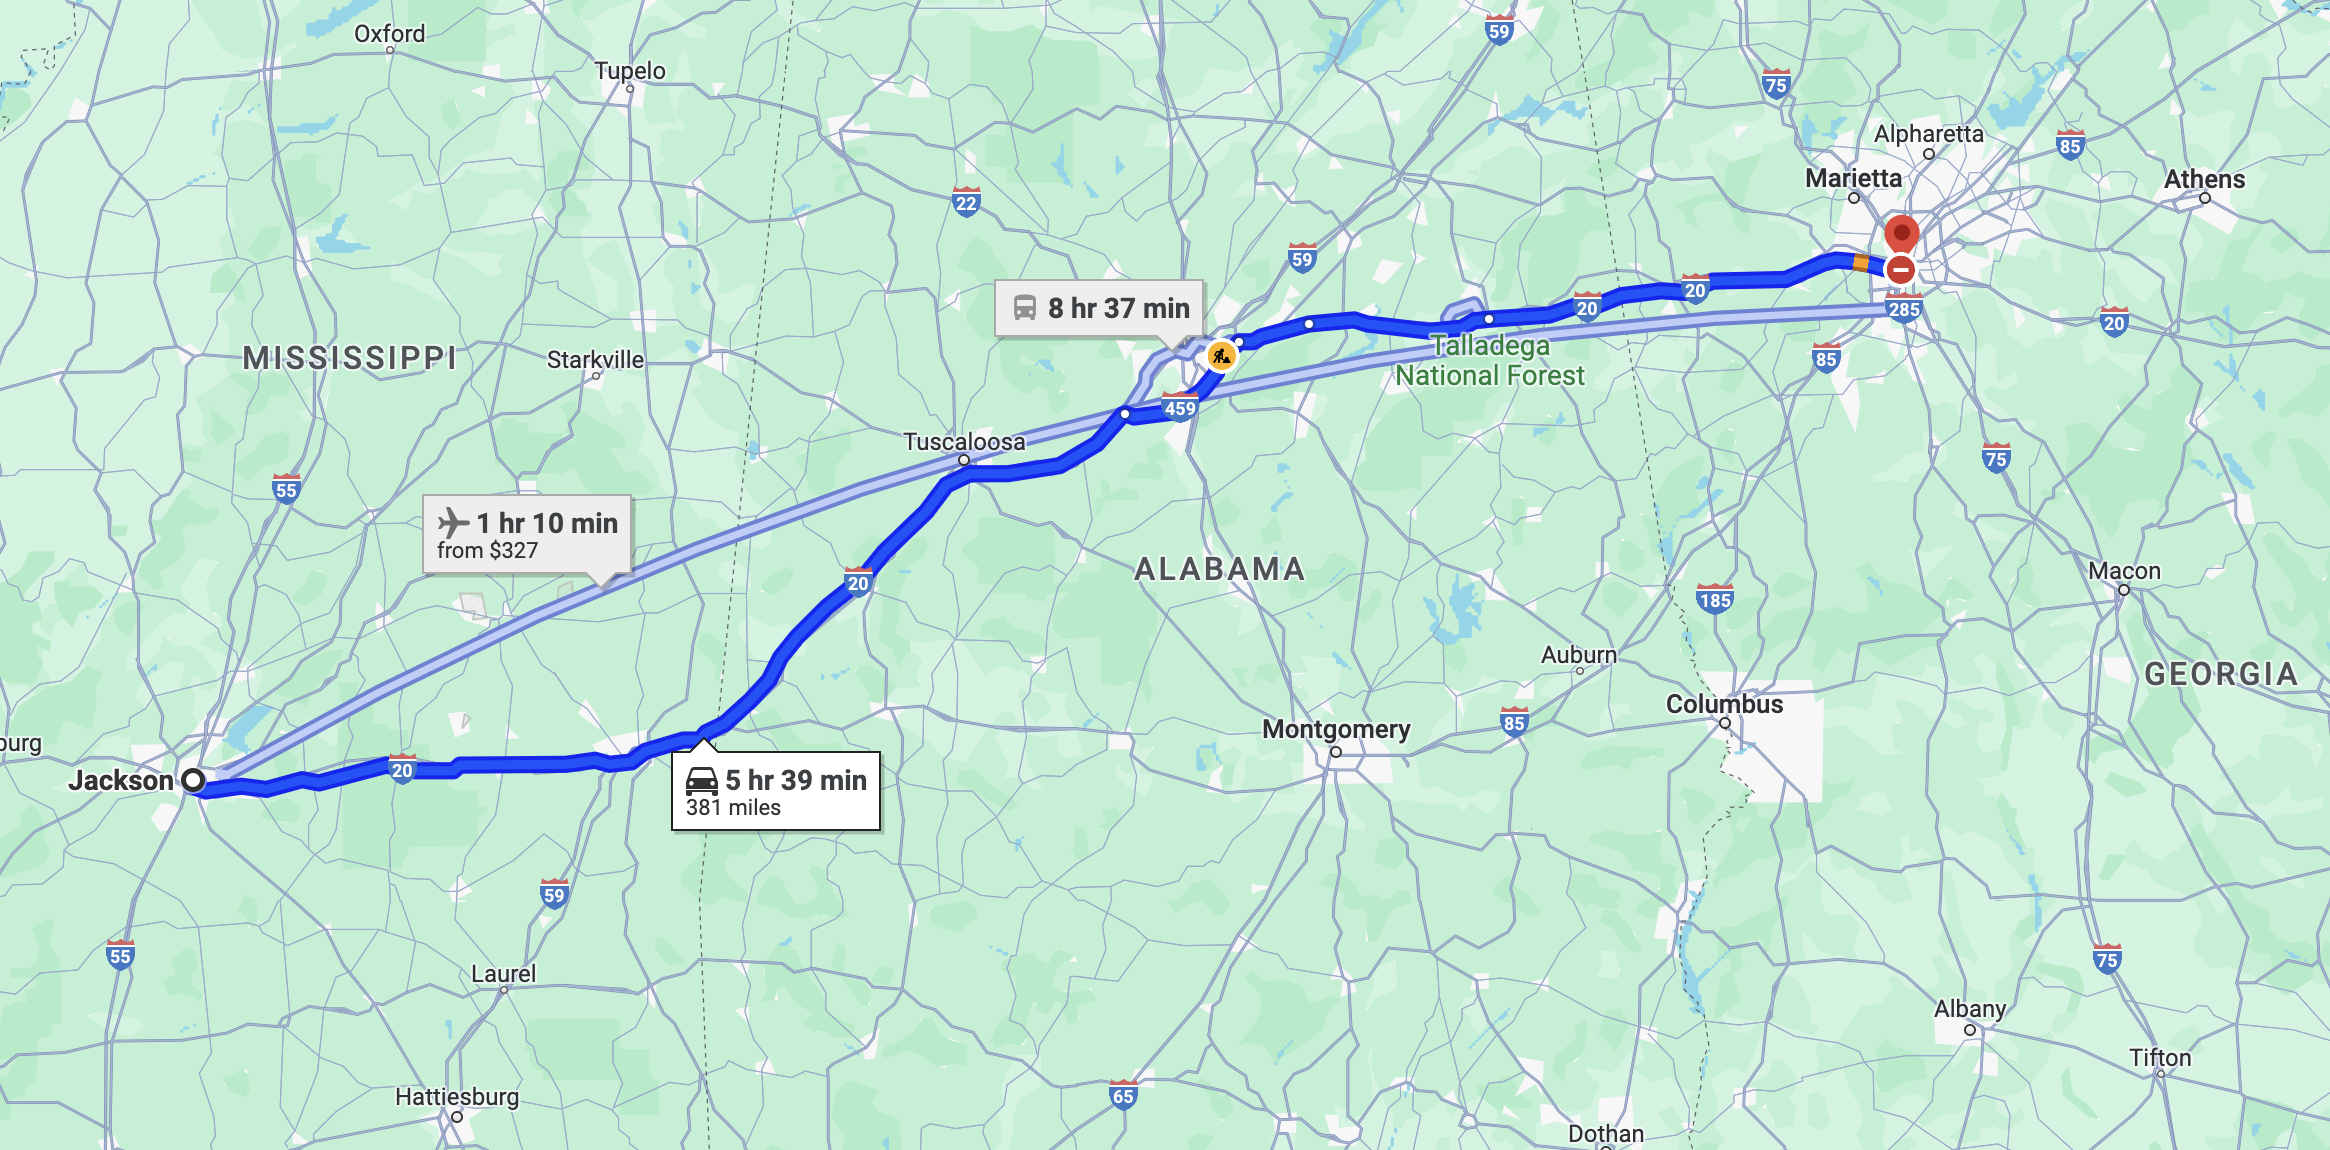

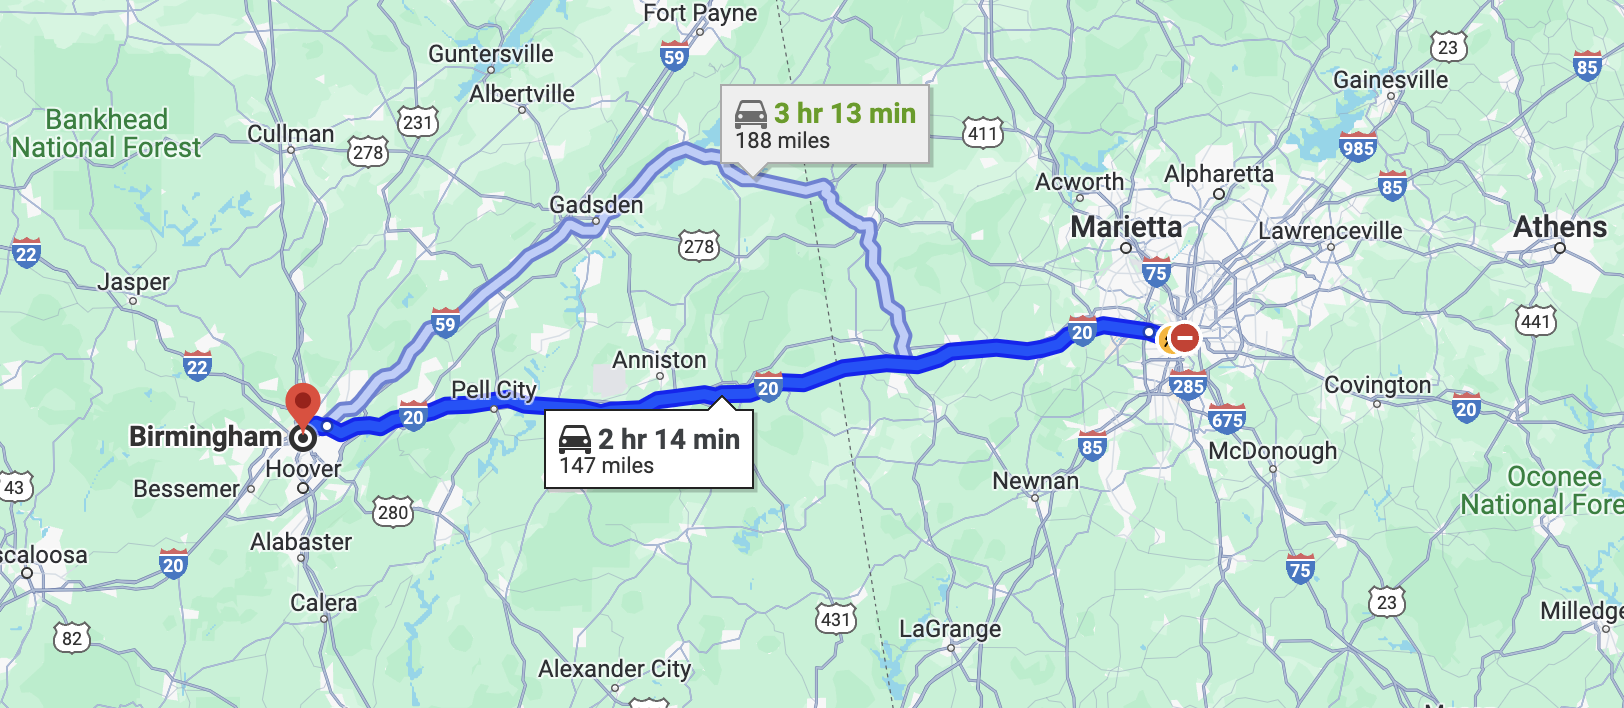